## Notes / ToDo
- Cut off the likelihood for high / problematic dedx values (only focus on values located in the region around the peak)
- Look into developing analytic likelihood based on the mpv fit. This would most likely have to take the pitch into account 
- See if single muon fit mpvs have any correlation with fit mpvs. Build likelihood from that alone.


- Langau pdf maximum deviates slightly from the mpv parameter used to generate it. This is clearly because of the Gaussian convolution, but I thought it was worth mentioning. Important to note that this deviation is in the wrong direction---the true maximum is slightly *greater* than the one measured, and so this correction does not solve the problem of the Langau mpvs being higher than expected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import matplotlib.ticker as mticker 
from util.cer_util import CER
import util.cer_util
import warnings
import pylandau
import datetime
import os
from importlib import reload
warnings.filterwarnings('ignore')
plt.style.use('stylesheets/eloss.mplstyle')

In [2]:
titles = ['Base Likelihood',
          'Cut Likelihood',
          'Cut and Fixed-Width Likelihood',
          'Fixed-Width Likelihood',
          'High-Pitch Cut Likelihood',
          'High-Pitch Likelihood',
          'Low-Pitch Cut Likelihood',
          'Low-Pitch Likelihood',
          'Narrow Energy Cut Likelihood (1-10 GeV)',
          'Narrow Energy Likelihood (1-10 GeV)']

Move this to a the theory module or something, it is really annoying that this is non-normalized.

In [3]:
def langau_pdf(dedx, mpv, eta, sig):
    return eta * pylandau.get_langau_pdf(dedx, mpv, eta, sig)

In [4]:
def savefig(fig, name):
    date = datetime.datetime.now()
    month_day = f'{date.month}-{date.day}/'
    path = r'./plots/' + month_day + name
    fig.savefig(path, bbox_inches='tight')
    print(f'Saved to {path}')

In [5]:
import time
CER = reload(util.cer_util).CER
cer = CER(dedx_max=10)
start = time.perf_counter()
cer.load_muons()
end = time.perf_counter()
t1 = end-start

print(f'Loading time: {t1//60:.0f}m, {t1%60:.2f}s')

Loading Data...
Loaded!
Slimming...
Will remove 5971 particles
Loading time: 0m, 9.37s


## Percent Accuracy
Quick check for how many times we got the correct answer (where the true energy was inside the energy bin predicted by the likelihood)

In [6]:
def get_accuracy(likedf):
    num_correct = likedf.query('truth > reconstructed_min & truth < reconstructed_max').shape[0]
    num_particles = likedf.shape[0]
    percent_correct = num_correct/num_particles * 100
    return percent_correct

- For the base likelihood with the statistically binned fits, accuracy is 5.31%. This is about the same accuracy as randomly guessing (statisitcally insignificant difference between this and randomly guessing).
- For the likelihood with $1.25 < \text{dedx} < 6$ as the cutoff for the likelihood contribution, the accuracy is 6.91%---a statistically significant improvment over randomly guessing, but obviously not ideal.
- For the likelihood with no cutoff and fixed langau widths (quadrature mean, essentially mpv only), the accuracy is 6.14%

## Raw heatmap of reconstructed energy vs true energy

In [7]:
def plot_2d_hist(likedf, fitdf, ax):
    ebins = fitdf.e_min.to_list()
    ebins.append(fitdf.e_max.iloc[-1])
    ebins = np.array(ebins)
    
    x = np.linspace(0, 100, 1000)

    truth = likedf.truth
    reconstructed = likedf[["reconstructed_min", "reconstructed_max"]].mean(1)
    counts, xedges, yedges, _ = ax.hist2d(truth, reconstructed, bins=[ebins,ebins], norm=LogNorm(0.7), cmap='gist_heat_r')
    ax.plot(x,x, color='k', ls='--') # Plot the expectation, which is ideally perfect reconstruction (a 45 degree line)
    ax.set_xlabel('True Energy (GeV)')
    ax.set_ylabel('Reconstructed Energy (GeV)')
    ax.set_title('TE vs. RE')
    ax.set_ylim(0.5,45) # Cuts off the bins that comprise the border of the image, these bins continue to either 0.1 or 100 GeV, but drawing them fully makes the graph confusing
    ax.set_xlim(0.5,45)
    ax.set_xscale('log')
    ax.set_yscale('log')
    return counts, xedges, yedges

In [8]:
def plot_averages(likedf, counts, xedges, yedges, ax):
    acc = get_accuracy(likedf)
    
    x = np.linspace(0, 100, 1000)
    REs = 10**((np.log10(yedges[1:])+np.log10(yedges[:-1]))/2)
    TEs = 10**((np.log10(xedges[1:])+np.log10(xedges[:-1]))/2)
    average_reconstruction = [ np.sum(xcount*REs/np.sum(xcount)) for xcount in counts ]
    
    ax.errorbar(TEs, average_reconstruction, marker='o', label=f'Average E bin \nCorrect RE rate: {acc:.2f}%', ls='')
    ax.set_title('Average R.E. vs. T.E.')
    ax.set_ylabel('Average R.E. (GeV)')
    ax.set_xlabel('True Energy (GeV)')
    ax.plot(x,x, color='k', ls='--', label='Expectation')
    ax.legend()
    ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()

In [9]:
def re_format(ax):
    ax.xaxis.set_minor_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_minor_locator(mticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

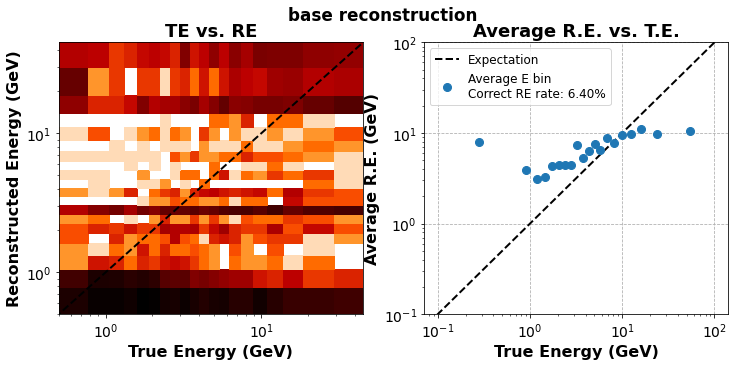

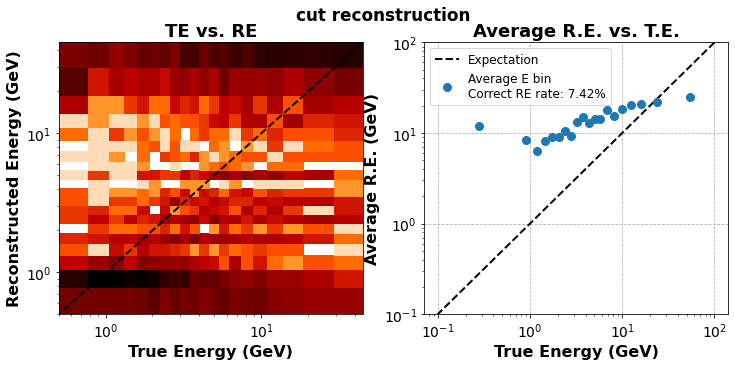

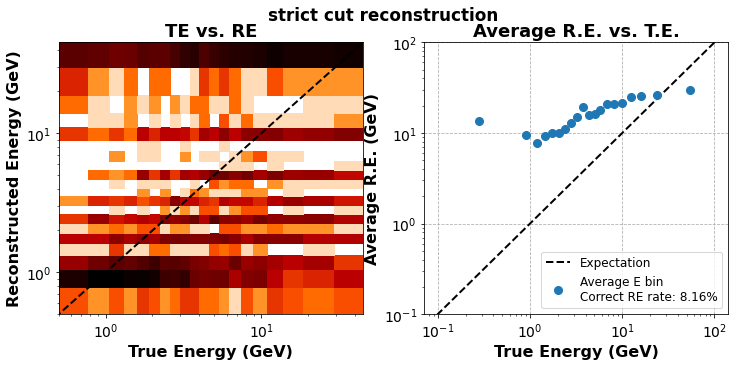

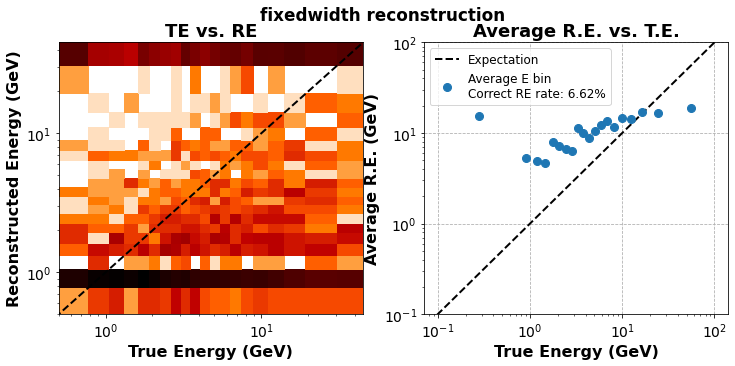

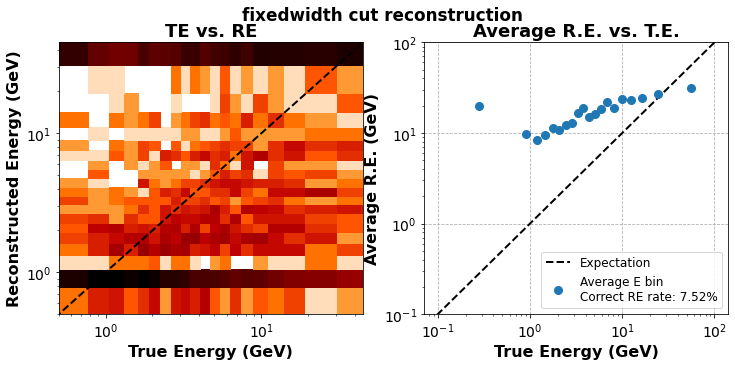

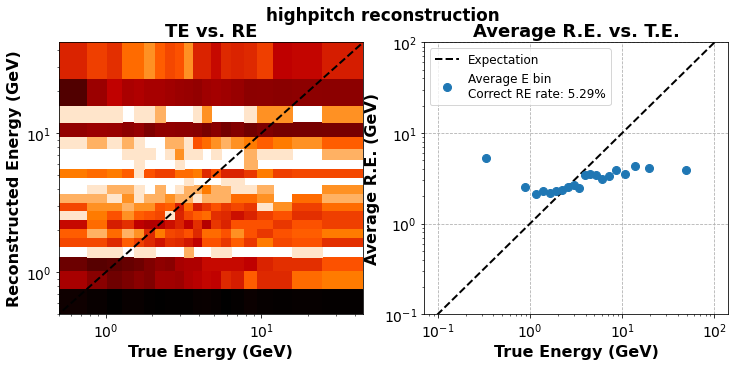

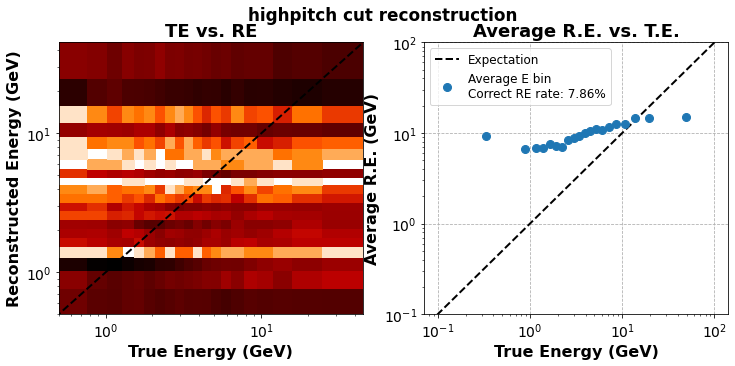

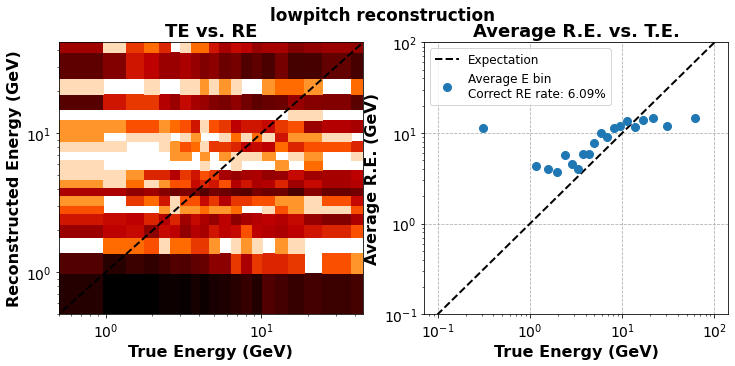

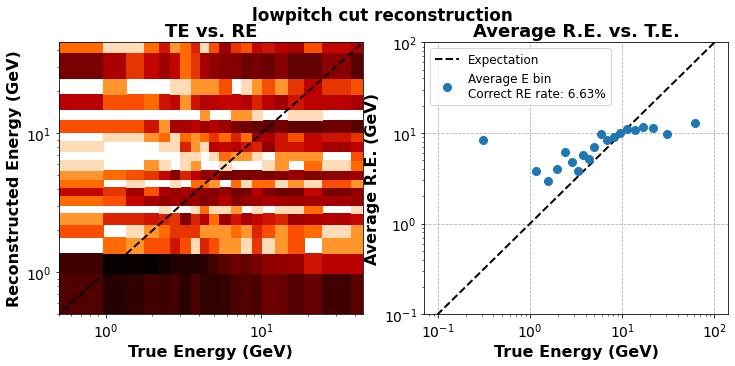

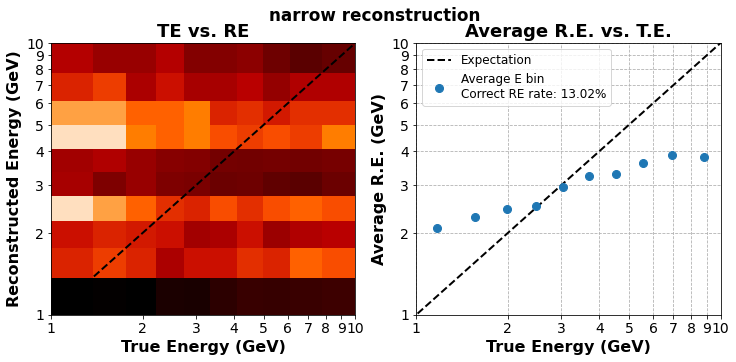

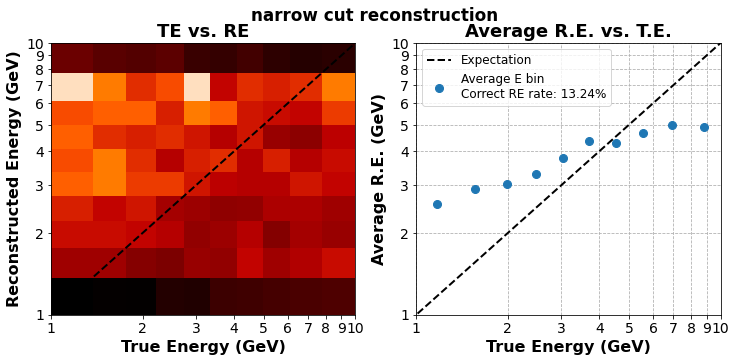

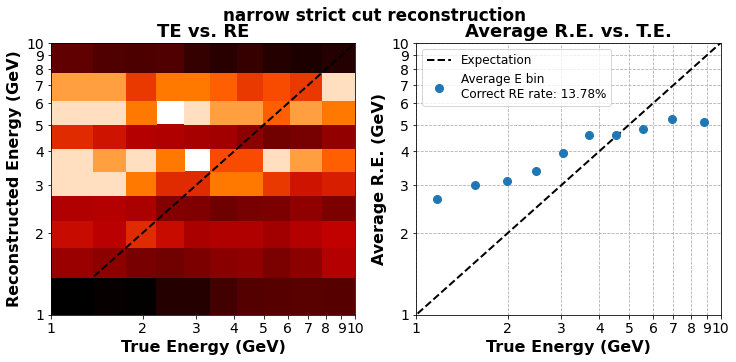

In [10]:
plt.rcParams['axes.grid']=False
keys_to_plot = ['base', 'base_c', 'base_sc', 'base_fw', 'base_cfw', 'hpitch', 'hpitch_c', 'lpitch', 'lpitch_c', 'narrow', 'narrow_c', 'narrow_sc']

def plot_likelihood_results(data_loc, fit_loc, title, save=False):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle(title, fontweight='bold')
    df = pd.read_csv(data_loc)
    fdf = pd.read_csv(fit_loc)
    ret = plot_2d_hist(df, fdf, axs[0])
    plot_averages(df, *ret, axs[1])
    if 'narrow' in data_loc:
        for ax in axs:
            re_format(ax)
            ax.set_ylim(1,10) 
            ax.set_xlim(1,10)
        
    fig.show()
    if save:
        savefig(fig, title.replace(' ', '_') + '_reconstruction.png')
    
for key in keys_to_plot:
    loc = cer.reconstructions[key]
    floc = cer.fits[key]
    plot_likelihood_results(loc, floc, loc[82:-4].replace('_', ' '), save=False)

plt.rcParams['axes.grid']=True

In [11]:
key = 'narrow_sc'
likedf = pd.read_csv(cer.reconstructions[key])
fitdf = pd.read_csv(cer.fits[key])

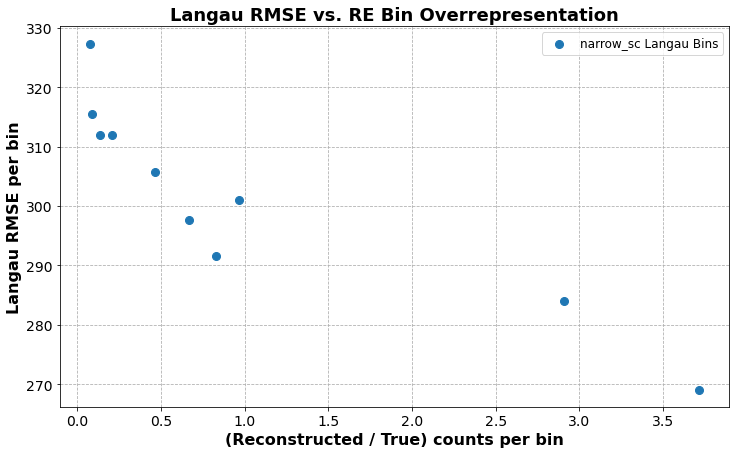

In [12]:
rmses = fitdf.rmse
                                       
overrepresentation = (likedf.reconstructed_min.value_counts() # True counts per bin   
                     / np.histogram(likedf.truth, [fitdf.e_min.to_list()[0]] + fitdf.e_max.to_list())[0]) # Expected counts per bin
fig = plt.figure()
plt.scatter(overrepresentation, rmses, label=key + ' Langau Bins')
plt.title('Langau RMSE vs. RE Bin Overrepresentation')
plt.xlabel('(Reconstructed / True) counts per bin')
plt.ylabel('Langau RMSE per bin')
plt.legend()
plt.show()

I think this is a significant indication that there is something fundamentally wrong with the methods applied here. By not accounting for measurement uncertainty in the original fits, the $\chi^2$ essentially boils down to the RMSE (assuming unit uncertainty). If all the data had the same individual uncertainty, then this statistical binning should be fine and the RMSE should be almost identical between the fits (since $RMSE\propto \chi^2$ and $\chi^2\approx N$ if the fit is good). This is not what we see here. Instead, the RMSE varies significantly between fits, indicating that there is some further uncertainty that is not accounted for. Whatever this uncertainty is, accounting for it should make $\chi^2$ for each fit approximately the same.
My reasoning for thinking that this correlation is causative is as follows. When making the fits for each bin, we use the same amount of data points between fits, therefore, the RMSE is a direct indication of how far, on average, the individual data are from the final fit value. Take a bin with high RMSE, and a muon in that energy bin. The muon could have some energy loss distribution that is quite different from the fit in that bin; in fact it is almost guaranteed that it will due to the higher RMSE in that fit (since the data used to create the fit is the same as the data which is reconstructed in the end). But the likelihood doesn't *know* that that particular fit deserves a wider berth of acceptance than the others; it weighs each fit equally. Thus, it is likely that the muon in this energy bin is reconstructed in another energy bin.

## Plot Langau Distributions

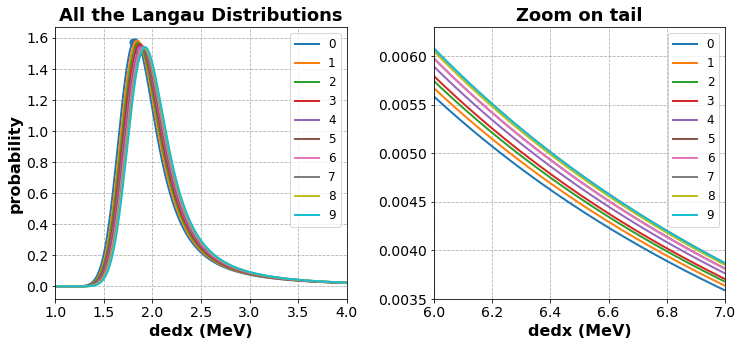

In [15]:
from scipy.optimize import minimize

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax0, ax1 = axs
for i, l_ in fitdf.iterrows():
    x_ = np.linspace(0,7,1000)
    y_ = np.array([ langau_pdf(x, l_[0], l_[1], l_[2]) for x in x_ ])
    
    # Plot full Landaus
    ax0.plot(x_,y_, ls='-', label=i)
    ax0.legend()
    ax0.set_xlim(1,4)
    ax0.scatter([l_.mpv],[langau_pdf(l_.mpv, l_.mpv, l_.eta, l_.sigma)],s=50)
    
    # Plot zoom on tail
    ax1.plot(x_,y_, ls='-', label=i)
    ax1.legend()
    ax1.set_xlim(6,7)
    ax1.set_ylim(0.0035,0.0063)    

    
plt.subplots_adjust(wspace=0.3)
ax0.set_xlabel('dedx (MeV)')
ax1.set_xlabel('dedx (MeV)')
ax0.set_ylabel('probability')
ax0.set_title('All the Langau Distributions')
ax1.set_title('Zoom on tail')

plt.show()

The slight variations in the shapes of these distributions lead to large favorability of certain Landau bins over the others. Might be worthwhile to look into the probability of the maximum value vs how favorable the bin is compared to surrounding bins. (*Attempted, and failed*) Maybe if we force the spreads ($\eta$ and $\sigma$) to be the same for each distribution, the horizontal offsets alone will be able to more accurately pick out the information we want. This might be equivalent to the method of just looking at the mpvs rather than the whole distribution.
- Another thing to note is that the mpv parameters are not actually the most probable values in this plot. This is because of the Gaussian convolution, but for now, it should not matter.

## Characterization of the Accuracy

I try to characterize the accuracy (the linear displacement between the true value minus the mean of the reconstructed bins). Then I plot this against the true and reconstructed energies to see if there is some correlation between them, i.e. are we more accurate in reconstructing low-energy, mid-energy, high-energy muons? Are muons we in certain energy bins more accuracte than others?

The results don't really say much, just that the muons we reconstructed to be in the highest energy bins tended to have true energy much lower, and the muons in the lower energy bins tended to have energy much higher than predicted.

In [84]:
accuracy = truth - reconstructed
display(accuracy)

0        4.927260
1        0.250738
2       18.440078
3        5.654370
4        3.132545
          ...    
4118     0.944467
4119     2.301370
4120    -6.413209
4121     2.666206
4122     5.622969
Length: 4123, dtype: float64

Text(0, 0.5, 'Accuracy')

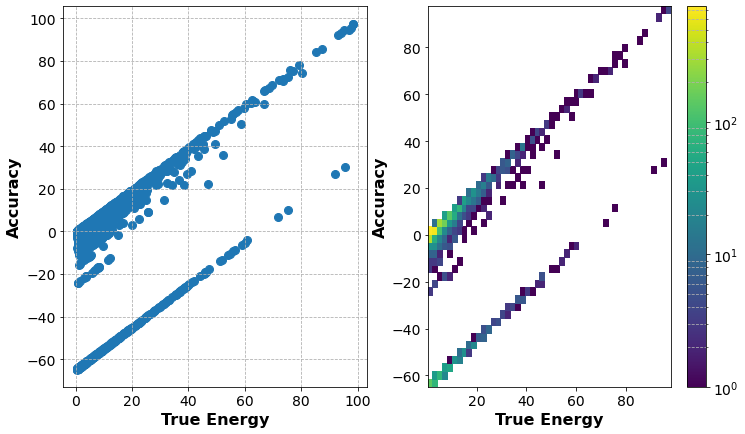

In [85]:
fig, axs = plt.subplots(1,2)
ax1, ax2 = axs
ax1.scatter(likedf.truth, accuracy)
ax1.set_xlabel("True Energy")
ax1.set_ylabel("Accuracy")
hh = ax2.hist2d(likedf.truth, accuracy, 50, norm=LogNorm())
fig.colorbar(hh[3], ax=ax2)
ax2.set_xlabel("True Energy")
ax2.set_ylabel("Accuracy")

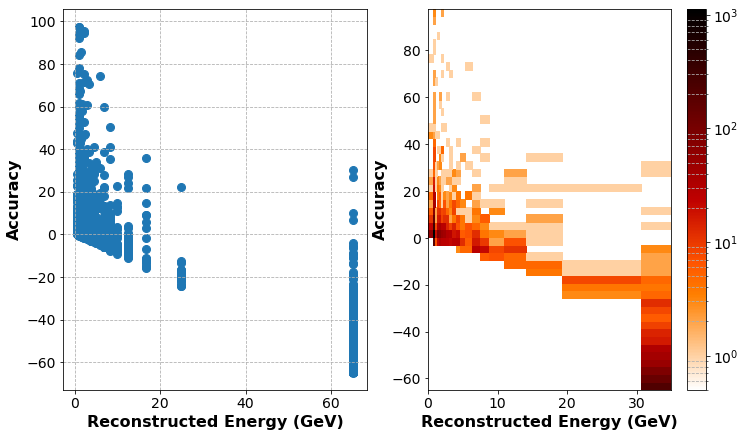

In [86]:
fig, axs = plt.subplots(1,2)
ax1, ax2 = axs
ax1.scatter(reconstructed, accuracy)
ax1.set_xlabel("Reconstructed Energy (GeV)")
ax1.set_ylabel("Accuracy")
hh = ax2.hist2d(reconstructed, accuracy, [ebins, 50], norm=LogNorm(vmin=.5), cmap='gist_heat_r')
fig.colorbar(hh[3], ax=ax2)
ax2.set_xlabel("Reconstructed Energy (GeV)")
ax2.set_ylabel("Accuracy")
ax2.set_xlim(0,35)
plt.show()

## Binned Distributions at certain true / reconstructed energies

In [20]:
re = likedf[["reconstructed_min", "reconstructed_max"]].mean(1)

In [21]:
def plot_re_dist(telo, tehi, highlight=False, otherdist=None, save=False, i=0):
    df_ebin = likedf.query(f'truth < {tehi} & truth > {telo}')
    re_centers = df_ebin[["reconstructed_min", "reconstructed_max"]].mean(1)
    if otherdist is not None:
        re_centers = otherdist
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.gca()
    counts = ax.hist(re_centers, ebins, edgecolor='black', lw = '1.2')[0]
    ax.plot([],[],label=f'tot. = {np.sum(counts):.0f} particles')
    if highlight:
        minloc, maxloc = np.digitize([telo, tehi], ebins) - 1
        if np.isin([tehi], ebins)[0]:
            maxloc -= 1
        highlight_bins = [telo, *ebins[minloc+1:maxloc], tehi]
        ax.hist(re_centers, highlight_bins, color='r', edgecolor='black', lw = '1.2', label="correct bin")
        
    ax.set_xlabel('Reconstructed Energy (GeV)')
    ax.set_ylabel('Counts')
    ax.set_title(fr'R.E. Distribution for T.E.$\in$({telo:.2f},{tehi:.2f}) GeV')
    ax.set_xlim(0, 35)
    ax.legend()
    fig.show()
    if save:
        savefig(fig, fr'RE_Dists_Fixedwidth/RE_dist_for_TE_bin{i}.png')
    return fig, counts

In [22]:
def plot_te_dist(relo, rehi, highlight=False, save=False, i=0):
    df_ebin = likedf.query(f'(reconstructed_min+reconstructed_max)/2 < {rehi} & (reconstructed_min+reconstructed_max)/2 > {relo}')
    te = df_ebin.truth
    fig, _ = plot_re_dist(relo, rehi, highlight=highlight, otherdist=te)
    plt.xlabel('True Energy (GeV)')
    plt.title(fr'T.E. Distribution for R.E.$\in$({relo:.2f},{rehi:.2f}) GeV')
    if save:
        savefig(fig, fr'RE_Dists/TE_dist_for_RE_bin{i}.png')

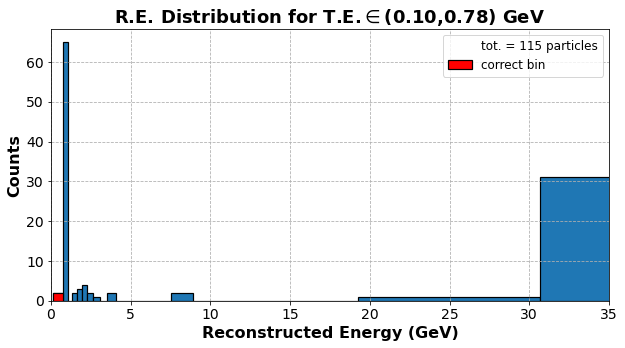

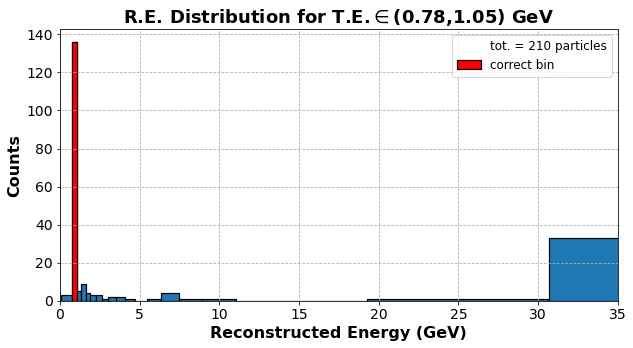

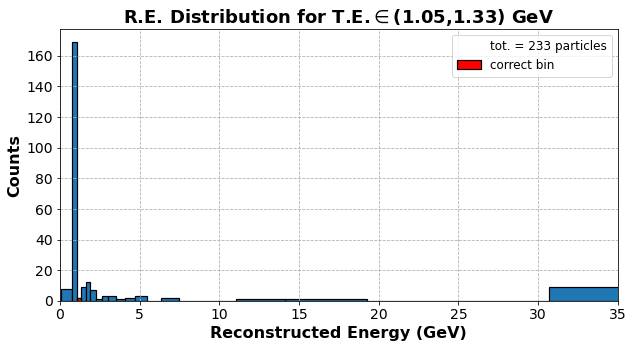

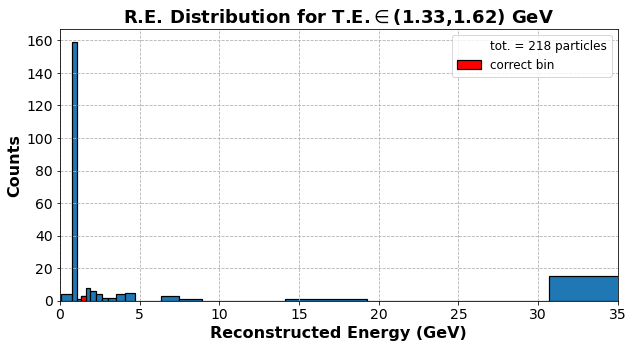

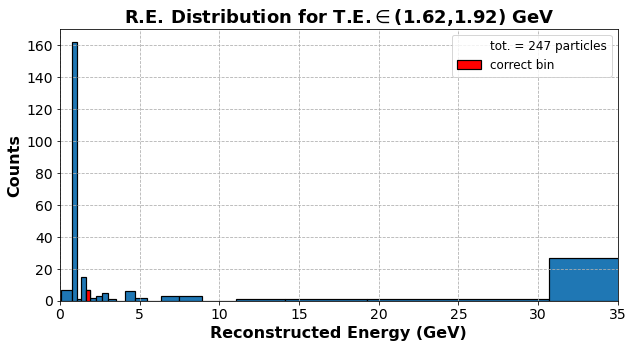

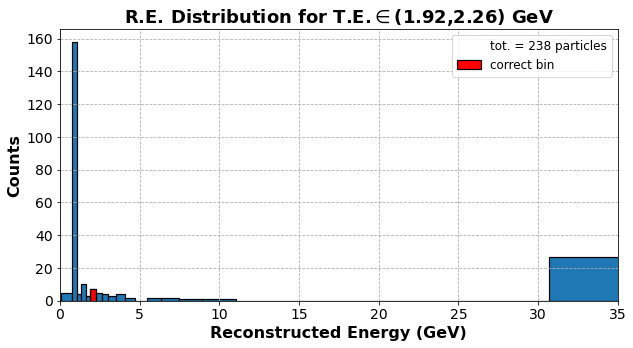

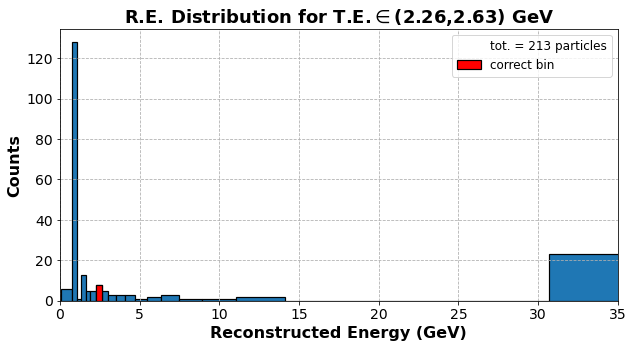

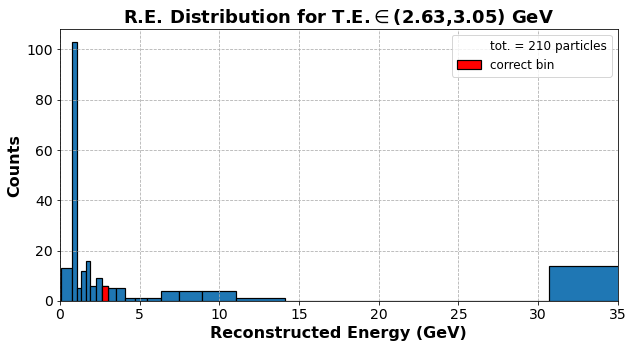

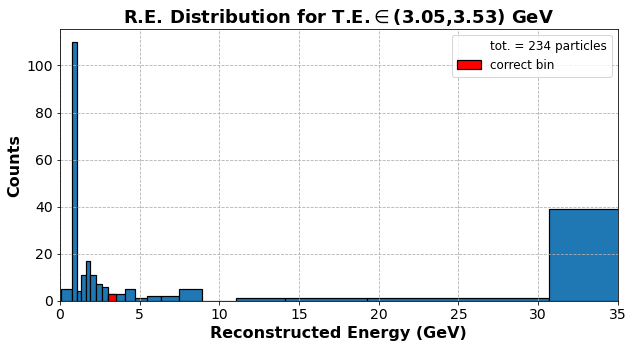

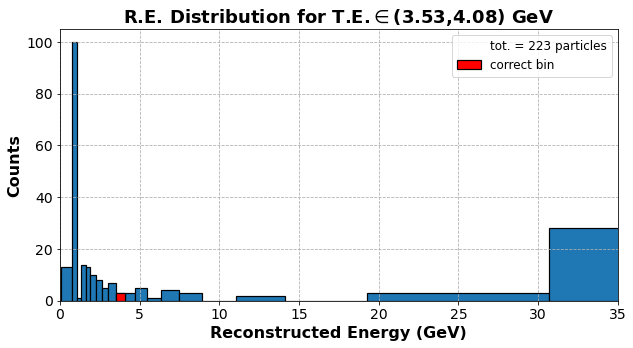

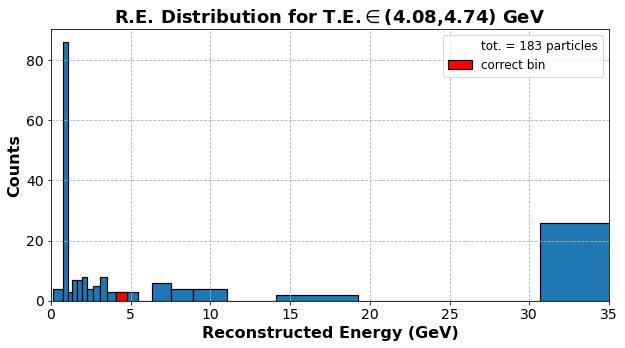

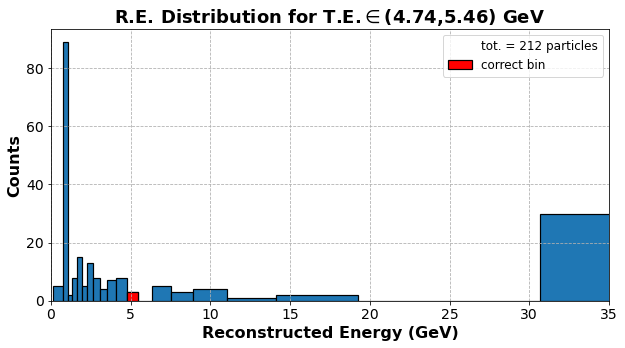

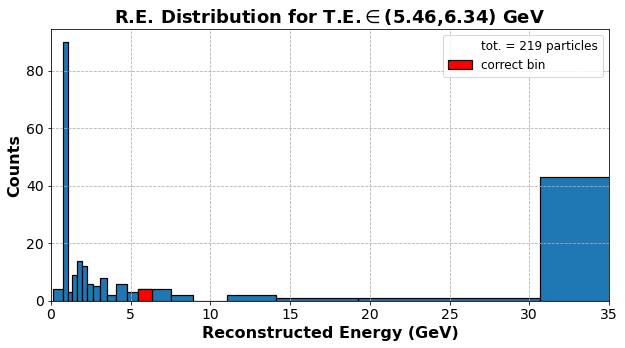

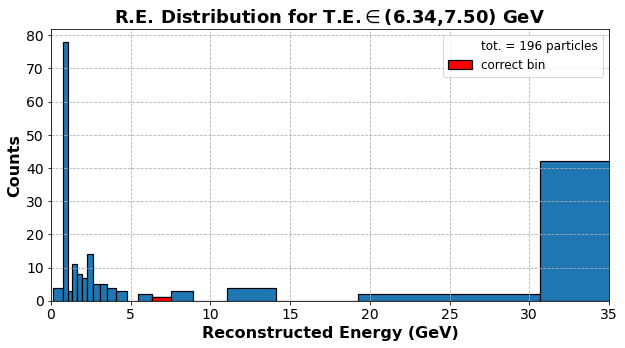

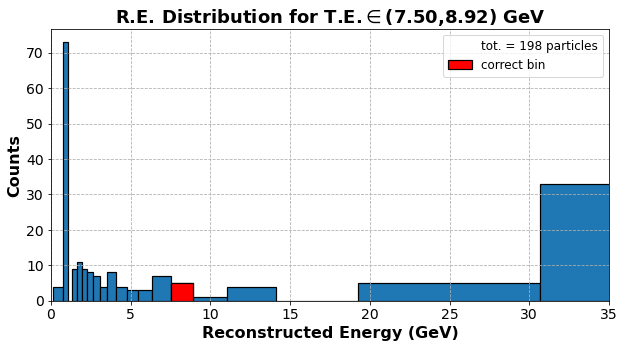

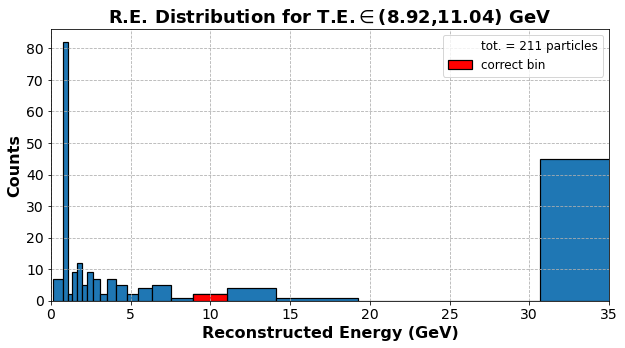

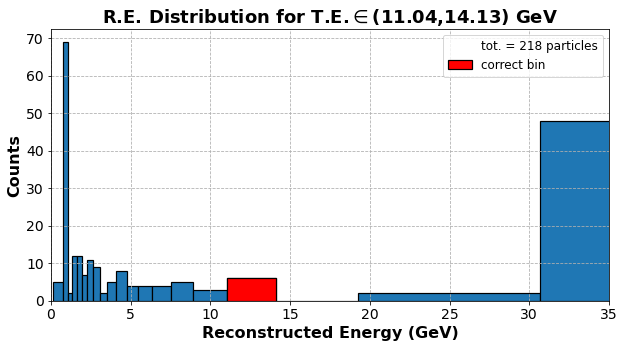

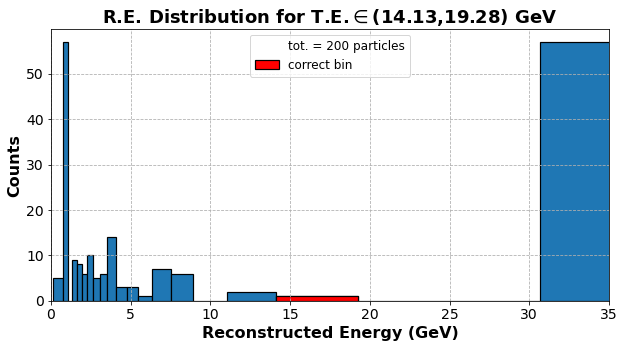

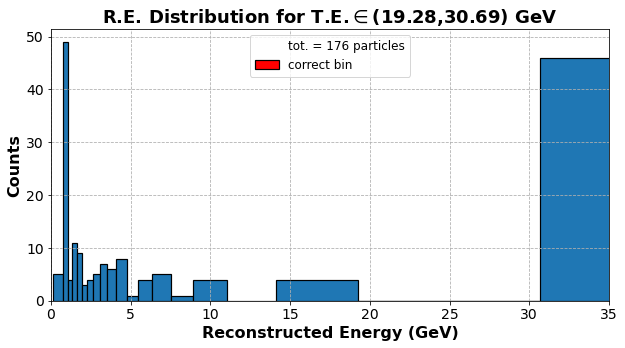

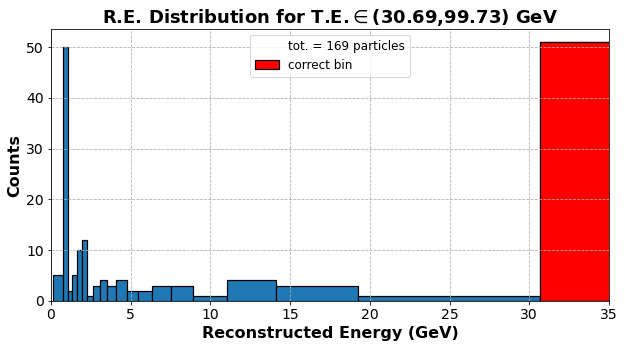

In [23]:
for i in range(0,len(ebins)-1):
    counts = plot_re_dist(ebins[i], ebins[i+1], highlight=True)

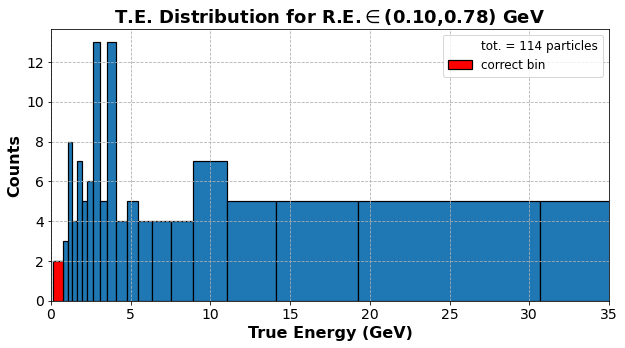

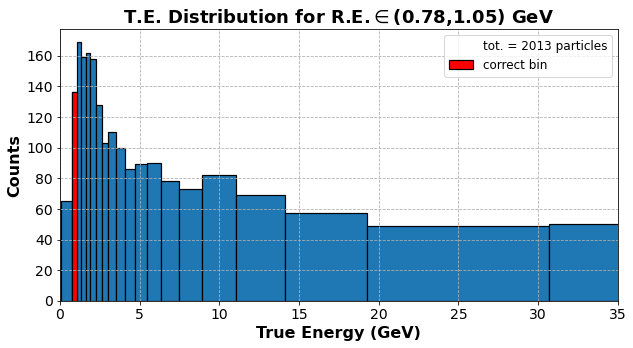

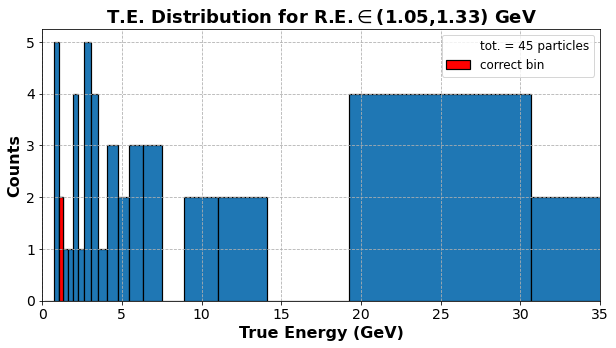

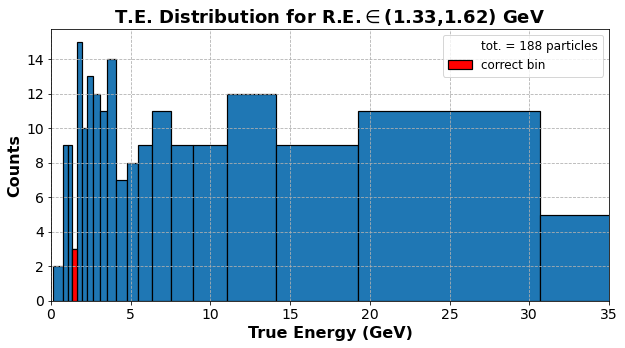

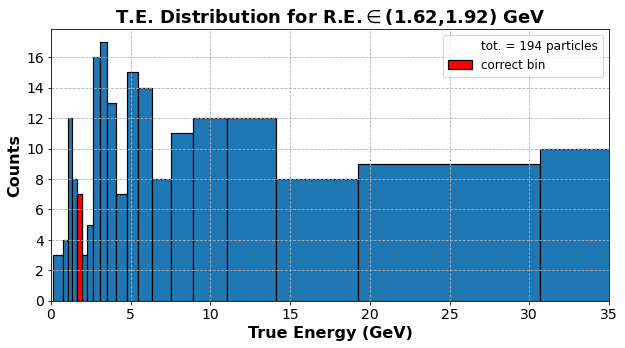

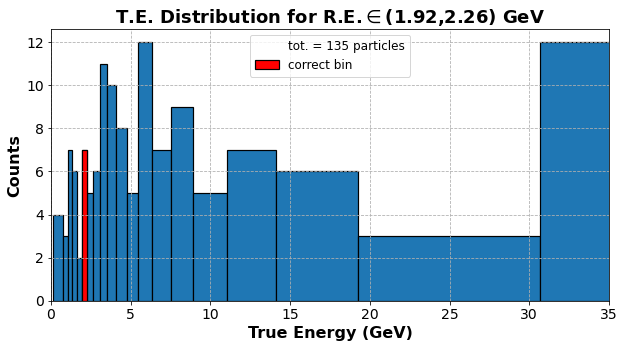

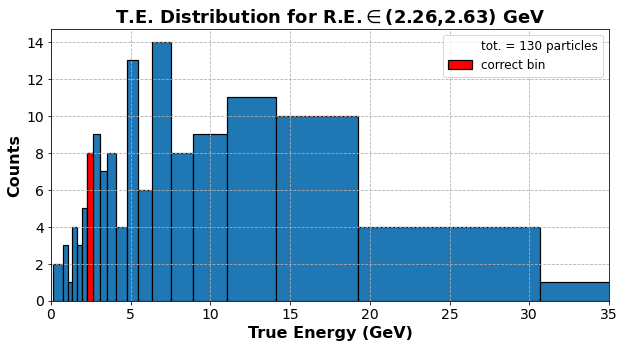

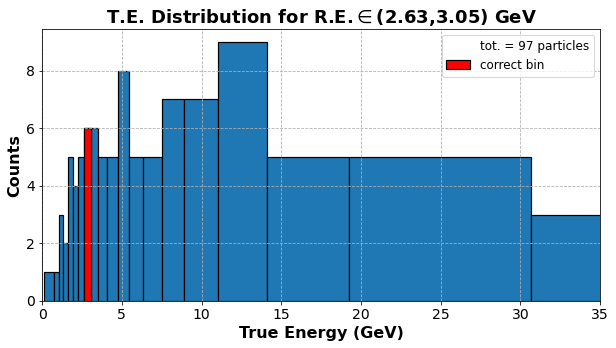

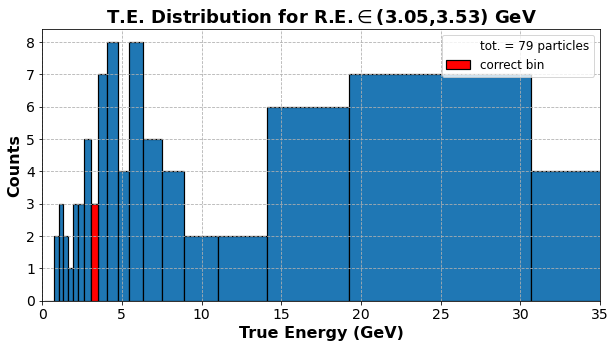

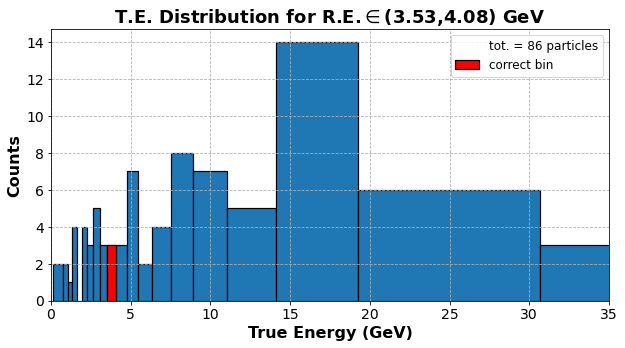

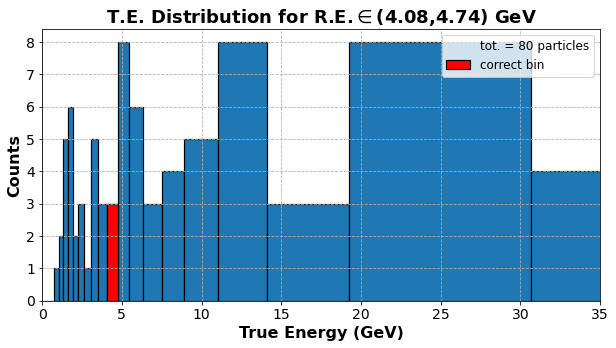

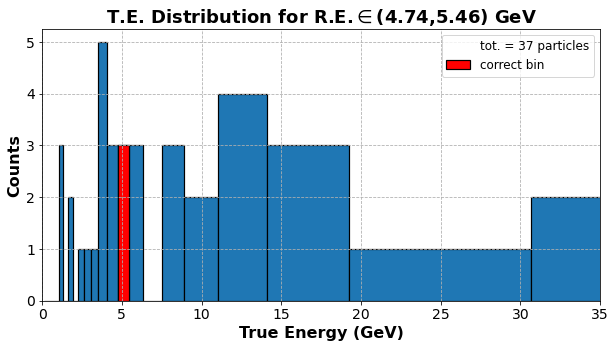

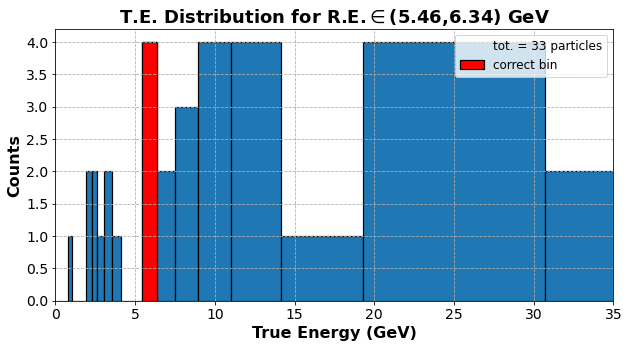

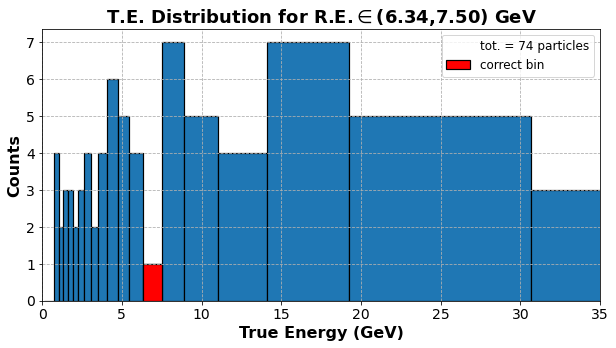

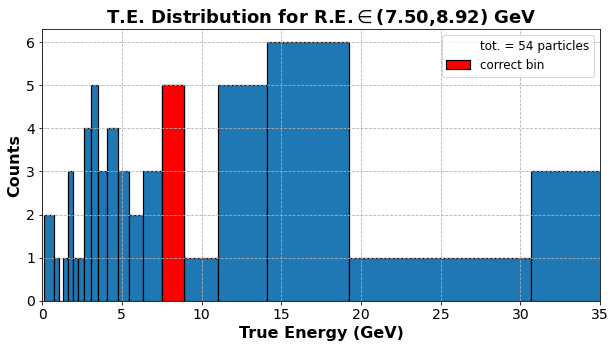

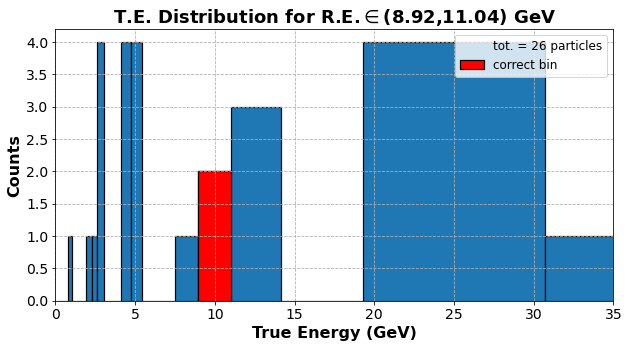

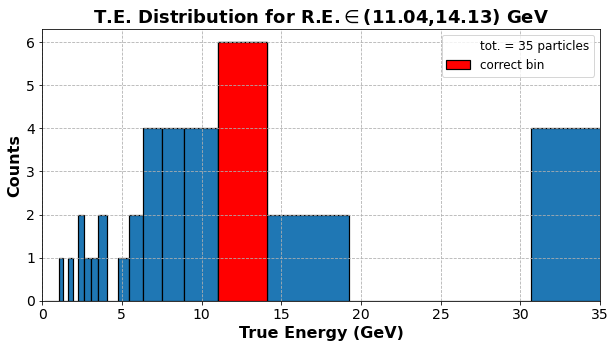

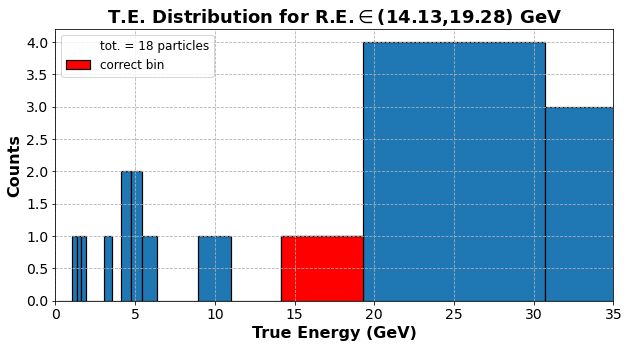

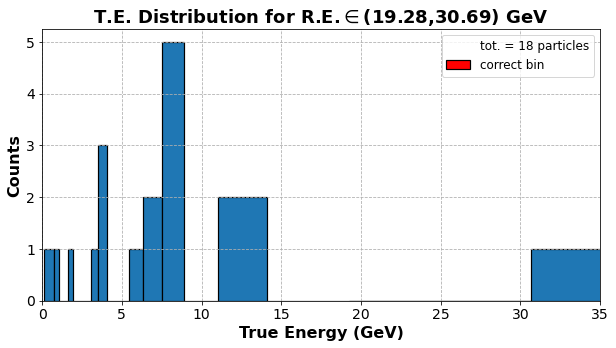

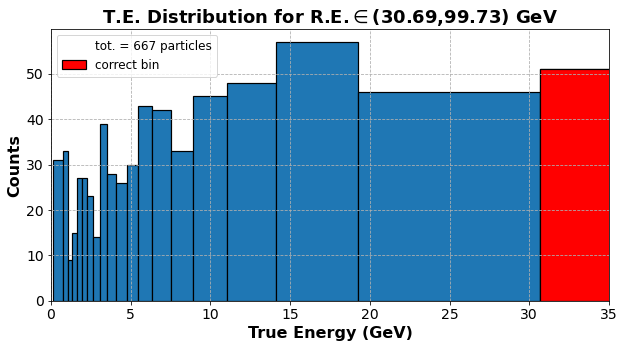

In [24]:
for i in range(0,len(ebins)-1):
    counts = plot_te_dist(ebins[i], ebins[i+1], highlight=True)

Multiply by prior probability distribution to obtain more appropriate probability for the likelihood. This will require knowing the prior, which can just be the probability distribution of cosmic muons as a function of energy, which I assume is generally well-understood.

## Dependence on track length
Here I explore further the idea that the track length of the particle has a confounding effect on the likelihood

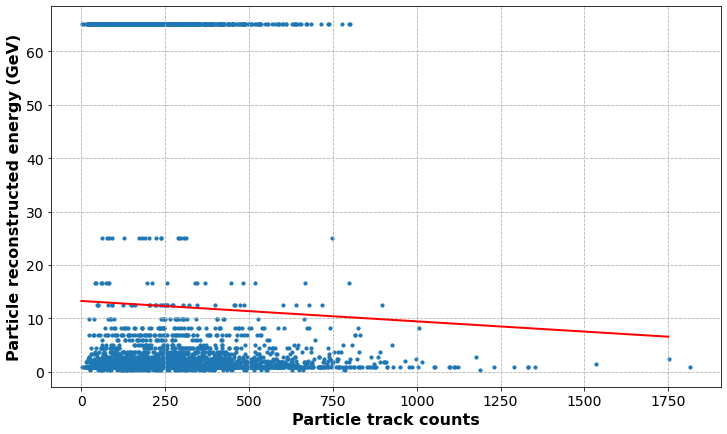

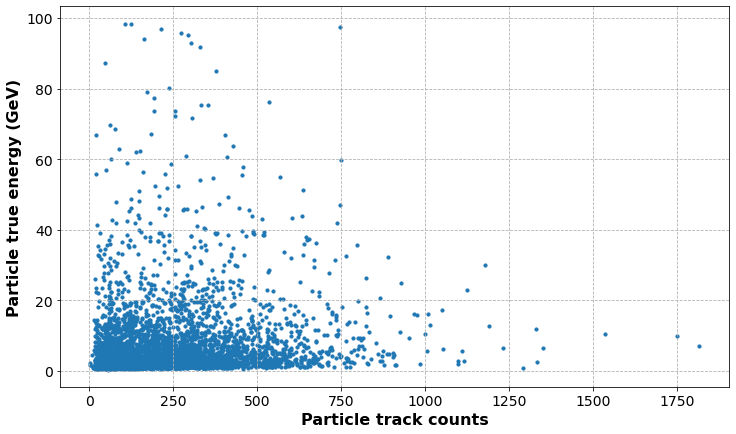

In [25]:
trkl = []
for mu in cer.muons:
    l = mu.dedx_y.shape[0]
    trkl.append(l)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(lambda x,a,b: a*x+b, trkl, re)
fig = plt.figure()
plt.scatter(trkl, re, s=10)
_x = np.linspace(0,1750, 1000)
_y = popt[0] * _x + popt[1]
plt.plot(_x,_y, ls='-', c='r')
plt.xlabel('Particle track counts')
plt.ylabel('Particle reconstructed energy (GeV)')
plt.show()
plt.figure()
plt.scatter(trkl, truth, s=10)
plt.xlabel('Particle track counts')
plt.ylabel('Particle true energy (GeV)')
plt.show()

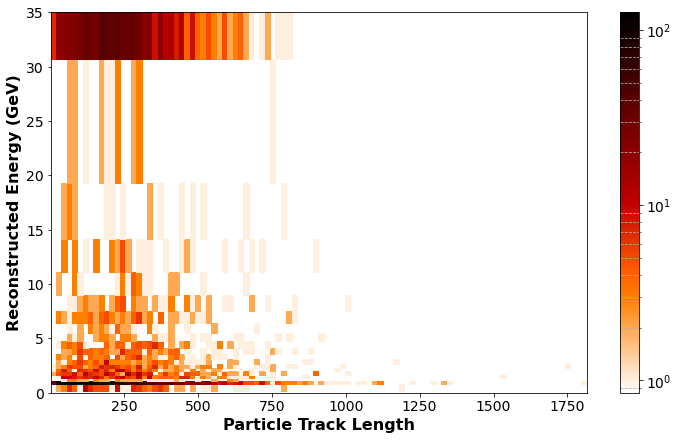

In [26]:
plt.hist2d(trkl, re, bins=[100, ebins], norm=LogNorm(vmin=0.85), cmap='gist_heat_r')
plt.ylim(0,35)
plt.colorbar()
plt.ylabel('Reconstructed Energy (GeV)')
plt.xlabel('Particle Track Length')
plt.show()

## Selection Cuts
Just want to visualize the selection cuts I have made quickly here. With the full dataset, I cannot load everything contiguously in memory, so I have to go a little lower-level here

In [87]:
import uproot
unfiltered_pitches = []
with uproot.open('./data/simulated_cosmics_full.root:/nuselection/CalorimetryAnalyzer') as tree:
    unfiltered_pitches = tree.arrays('pitch_y', library='pd')

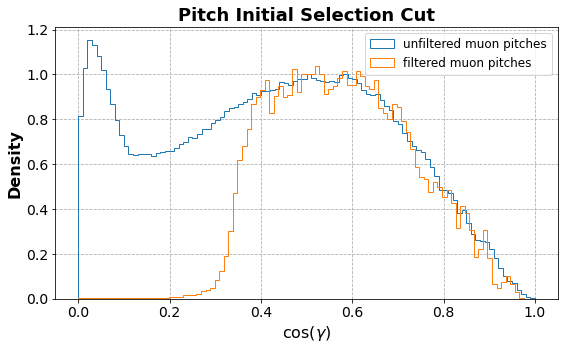

Average filtered pitch: 0.5174798375635936


In [91]:
fig = plt.figure(figsize=(9,5))
ucounts, ubins = np.histogram(0.3/unfiltered_pitches, 100)
plt.hist(ubins[:-1], ubins, weights=ucounts/ucounts[50], histtype='step', label='unfiltered muon pitches')

filtered_pitches = np.array([i for muon in cer.muons for i in muon.pitch_y])
fcounts, fbins = np.histogram(0.3/filtered_pitches, 100)
plt.hist(fbins[:-1], fbins, weights=fcounts/fcounts[50], histtype='step', label='filtered muon pitches')
plt.legend()
plt.xlabel(r'$\cos(\gamma)$')
plt.ylabel(r'Density')
plt.title('Pitch Initial Selection Cut')
plt.show()

print('Average filtered pitch:', 0.3/np.sum((fbins[1:]+fbins[:-1])/2*fcounts/np.sum(fcounts)))

In [29]:
unfiltered_dedx = []
with uproot.open('./data/simulated_cosmics_full.root:/nuselection/CalorimetryAnalyzer') as tree:
    unfiltered_dedx = tree.arrays('dedx_y', library='pd')

In [31]:
fig = plt.figure(figsize=(9,5))
ucounts, ubins = np.histogram(unfiltered_dedx[(unfiltered_dedx < 100) & (unfiltered_dedx != np.NaN)], 100)
plt.hist(ubins[:-1], ubins, weights=ucounts, histtype='step', label='unfiltered muon dedx')

filtered_dedx = np.array([i for muon in cer.muons for i in muon.dedx_y])
fcounts, fbins = np.histogram(filtered_dedx, 100)
plt.hist(fbins[:-1], fbins, weights=fcounts, histtype='step', label='filtered muon dedx')
plt.xlim(0, 500)
# plt.legend()
# plt.xlabel(r'$\cos(\gamma)$')
# plt.ylabel(r'Density')
# plt.title('Pitch Initial Selection Cut')
plt.show()

ValueError: autodetected range of [nan, nan] is not finite

<Figure size 648x360 with 0 Axes>